# Purpose

Aggregate the data about the power stations into a single file at the parish level in order to do the first-stage analysis

Change shapefile to geojson

In [1]:
import geopandas as gpd
import pathlib

root = pathlib.Path.cwd().parent

shp_file_path = root / "data/maps/Swedish_parishes_1926.shp"

# Read the shapefile
gdf = gpd.read_file(shp_file_path)

# Convert to GeoJSON in root, data/maps/Swedish_parishes_1926.geojson
gdf.to_file(root / "data/maps/Swedish_parishes_1926.geojson", driver='GeoJSON')

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Read the Excel file
power_stations_df = pd.read_excel(root / "data/power-stations/power-stations.xlsx")

# Read the GeoJSON file
parishes_gdf = gpd.read_file(root / "data/maps/Swedish_parishes_1926.geojson")


# Convert the power stations data into a GeoDataFrame
geometry = [Point(xy) for xy in zip(power_stations_df['longitude'], power_stations_df['latitude'])]
power_stations_gdf = gpd.GeoDataFrame(power_stations_df, geometry=geometry)
power_stations_gdf.set_crs("EPSG:4326", inplace=True, allow_override=True)
power_stations_gdf = power_stations_gdf.to_crs(parishes_gdf.crs)

# Perform the spatial join between the parishes and the power stations where the power stations are within the parishes
joined_gdf = gpd.sjoin(parishes_gdf, power_stations_gdf, how="inner", op="contains")

# Group by the parish ref_code and name, and the source of power to calculate the number of power stations and the total amount of power for each source
source_stats = joined_gdf.groupby(['ref_code', 'name_left', 'source_final']).agg({'amount_final': ['count', 'sum']}).reset_index()
source_stats.columns = ['Ref Code', 'Parish', 'Source', 'Number of Stations', 'Total Power']

# Pivot the source_stats DataFrame to create new columns for each source type
pivot_source_stats = source_stats.pivot_table(index=['Ref Code', 'Parish'], columns='Source', values=['Number of Stations', 'Total Power'], fill_value=0).reset_index()
# Flatten the MultiIndex columns
pivot_source_stats.columns = [' '.join(col).strip() for col in pivot_source_stats.columns.values]
# Reset the index
pivot_source_stats.reset_index(inplace=True)


# Calculate the total number of power stations and the total amount of power in each parish
total_stats = joined_gdf.groupby(['ref_code', 'name_left']).agg({'amount_final': ['count', 'sum']}).reset_index()
total_stats.columns = ['Ref Code', 'Parish', 'Total Stations', 'Total Power']

pivot_source_stats, total_stats

# Merge the pivot_source_stats and total_stats DataFrames
final_df = pd.merge(pivot_source_stats, total_stats, on=['Ref Code', 'Parish'])

parishes_gdf_to_join = parishes_gdf[['ref_code', 'name']]
# rename the columns to match the final_df
parishes_gdf_to_join.columns = ['Ref Code', 'Parish']

final_df_all_parishes = parishes_gdf_to_join.merge(final_df, how='left', left_on=['Ref Code', 'Parish'], right_on=['Ref Code', 'Parish'])

# Get the column names excluding 'Ref Code' and 'Parish'
columns_to_fill = [col for col in final_df_all_parishes.columns if col not in ['Ref Code', 'Parish']]

# Replace NaN values with 0
final_df_all_parishes[columns_to_fill] = final_df_all_parishes[columns_to_fill].fillna(0)

final_df_all_parishes.head()

# sample the data
final_df_all_parishes.sample(10)

final_df_all_parishes.columns

# Rename the columns to snake_case with a fomula
final_df_all_parishes.columns = [col.lower().replace(' ', '_') for col in final_df_all_parishes.columns]

# Save the final_df_all_parishes DataFrame as a CSV file with utf-8 encoding
final_df_all_parishes.to_csv(root / "data/power-stations/power-stations-by-parish.csv", index=False, encoding='utf-8')



c:\Users\User\Documents\Recon\paper-3-analysis\.venv\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Get parish area

In [4]:
df = pd.read_csv(root / "data/power-stations/power-stations-by-parish.csv")

parishes_gdf = gpd.read_file(root / "data/maps/Swedish_parishes_1926.geojson")

# calculate parish area
parishes_gdf['area'] = parishes_gdf.area

# select ref_code, area, geom_id
parishes_gdf = parishes_gdf[['ref_code', 'area', 'geom_id']]

# merge df and parishes_gdf on ref_code

df = df.merge(parishes_gdf, on='ref_code', how='left')

df.to_csv(root / "data/power-stations/power-stations-by-parish_with_area.csv", index=False)

Join treatment parishes

In [6]:
df = pd.read_csv(root / "data/power-stations/power-stations-by-parish_with_area.csv")

treated_parishes = pd.read_excel(root / "data/parishes/treated_parishes.xlsx")

# prepend "SE/" to parish_code and call it ref_code, add a leading zero to parish_code if it is less than 9 characters
treated_parishes['ref_code'] = treated_parishes['parish_code'].apply(lambda x: 'SE/' + str(x).zfill(9))
# keep only ref_code and iline, rename iline to treated
treated_parishes = treated_parishes[['ref_code', 'iline']]
treated_parishes = treated_parishes.rename(columns={'iline': 'treated'})

# join df and treated_parishes on ref_code
df = df.merge(treated_parishes, on='ref_code', how='left')

# fill NaN values in treated with 0 in treated
df['treated'] = df['treated'].fillna(0)

df.to_csv(root / "data/power-stations/power-stations-by-parish_with_area_and_treated.csv", index=False)

Now we must add in the distance from the central line to the center of the parish

In [7]:
from shapely.geometry import Point, LineString

parishes_gdf = gpd.read_file(root / "data/maps/Swedish_parishes_1926.geojson")

parishes_gdf['centroid'] = parishes_gdf.geometry.centroid

station1_coords = (12.272571287279908, 58.27550603306433)
station2_coords = (17.443262677788724, 60.5633613884066)

# Create line
line = LineString([station1_coords, station2_coords])

# Create a GeoDataFrame from the line
line_gdf = gpd.GeoDataFrame(geometry=[line], crs='EPSG:4326')

line_gdf = line_gdf.to_crs('EPSG:3006')
parishes_gdf = parishes_gdf.to_crs('EPSG:3006')

parishes_gdf['distance_to_line'] = parishes_gdf['centroid'].apply(lambda x: line_gdf.distance(x).min())

# convert distance_to_line to km
parishes_gdf['distance_to_line'] = parishes_gdf['distance_to_line'] / 1000


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the parishes, color by distance to line
parishes_gdf.plot(column='distance_to_line', cmap='YlOrRd', linewidth=0.8, ax=ax, legend=True)

# Plot the line
line_gdf.plot(color='blue', linewidth=2, ax=ax)

# Set the title
ax.set_title('Distance from Parishes to Line')

plt.show()


In [8]:
# export from parishes_gdf just the ref_code and distance_to_line columns
parishes_gdf[['ref_code', 'distance_to_line']].to_csv(root / "data/parishes/distance_to_line.csv", index=False)

In [9]:
# join to df on ref_code
df = pd.read_csv(root / "data/power-stations/power-stations-by-parish_with_area_and_treated.csv")

line_distance = pd.read_csv(root / "data/parishes/distance_to_line.csv")

# merge df and line_distance on ref_code
df = df.merge(line_distance, on='ref_code', how='left')

df.to_csv(root / "data/power-stations/power-stations-by-parish_with_area_and_treated_and_distance_to_line.csv", index=False)

Now we must find out of a parish is touching a treated parish

In [11]:
# read in df
df = pd.read_csv(root / "data/power-stations/power-stations-by-parish_with_area_and_treated_and_distance_to_line.csv")

# read in geojson file
parishes_gdf = gpd.read_file(root / "data/maps/Swedish_parishes_1926.geojson")
# keep only ref_code and geometry
parishes_gdf = parishes_gdf[['ref_code', 'geometry']]

# join df and parishes_gdf on ref_code
df = df.merge(parishes_gdf, on='ref_code', how='left')

df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:3006')

import geopandas as gpd

# Assuming df is a GeoDataFrame
treated = df[df['treated'] == 1]

def touches_treated(geometry):
    return treated.touches(geometry).any()

# return true = 1 if the geometry touches a treated parish, else return false = 0
df['touching_treated'] = df['geometry'].apply(touches_treated).astype(int)


In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the parishes that are not treated and don't touch treated parishes
df[(df['treated'] == 0) & (df['touching_treated'] == 0)].plot(ax=ax, color='white', edgecolor='black')

# Plot the parishes that are treated
df[df['treated'] == 1].plot(ax=ax, color='red', edgecolor='black')

# Plot the parishes that are not treated but touch treated parishes
df[(df['treated'] == 0) & (df['touching_treated'] == 1)].plot(ax=ax, color='yellow', edgecolor='black')

# Set the title
ax.set_title("Parish Treatment Map", fontsize=18)

plt.show()


In [12]:
# drop geometry column
df = df.drop(columns=['geometry'])

# write out
df.to_csv(root / "data/power-stations/power-stations-by-parish_with_area_and_treated_and_distance_to_line_and_touching_treated.csv", index=False)

Now we want to make a match between the parishes in the map and the parishes with population. 

In [14]:
geo_df = gpd.read_file(root / "data/maps/Swedish_parishes_1926.geojson")

parish_df = pd.read_excel(root / "data/parishes/cross-walk-1900-1910.xlsx")

# Convert ref_code_long to string and add leading zeros to make it 9 digits long
parish_df['ref_code_long'] = parish_df['ref_code_long'].astype(str).str.zfill(9)

# We need to extract the numeric part from ref_code in the geo_df
geo_df['ref_code_num'] = geo_df['ref_code'].str.extract('(\d+)')

# Now perform the left join
merged_df = geo_df.merge(parish_df, how='left', left_on='ref_code_num', right_on='ref_code_long', indicator=True)

# Find out which entries from geo_df did not find a match in parish_df
no_match_df = merged_df[merged_df['_merge'] == 'left_only']


In [15]:
from fuzzywuzzy import fuzz, process

def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2

    return df_1

# Create a new column in both dataframes with name and the first 4 digits of the ref_code
no_match_df['name_code'] = no_match_df['name_x'] + ' ' + no_match_df['ref_code_num'].str[:4]
parish_df['name_code'] = parish_df['name'] + ' ' + parish_df['ref_code_long'].str[:4]

# Apply fuzzy matching
fuzzy_match_df = fuzzy_merge(no_match_df, parish_df, 'name_code', 'name_code', threshold=90)

# Display the fuzzy_match_df
fuzzy_match_df.head()

c:\Users\User\Documents\Recon\paper-3-analysis\.venv\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\User\Documents\Recon\paper-3-analysis\.venv\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\User\Documents\Recon\paper-3-analysis\.venv\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to b

,geom_id,ref_code,name_x,type,type_id,start,end,geometry,ref_code_num,name_y,ref_code_long,_merge,name_code,matches
57,12632.0,SE/198301000,Köpings församling (U-län),Parish,parish,1920.0,9999.0,"POLYGON ((552216.972 6597947.028, 552045.202 6...",198301000,NaN,NaN,left_only,Köpings församling (U-län) 1983,
93,12680.0,SE/198003000,Västerås Badelunda församling,Parish,parish,0.0,9999.0,"POLYGON ((592839.821 6614478.867, 593148.869 6...",198003000,NaN,NaN,left_only,Västerås Badelunda församling 1980,
137,12739.0,SE/188002000,Örebro Olaus Petri församling,Parish,parish,1913.0,9999.0,"POLYGON ((516136.499 6573853.472, 516108.935 6...",188002000,NaN,NaN,left_only,Örebro Olaus Petri församling 1880,
169,12791.0,SE/128401000,Höganäs församling,Parish,parish,1852.0,9999.0,"POLYGON ((350172.032 6230962.028, 350771.344 6...",128401000,NaN,NaN,left_only,Höganäs församling 1284,
179,12804.0,SE/031902000,Skutskärs församling,Parish,parish,1909.0,9999.0,"POLYGON ((633637.000 6723856.502, 633380.955 6...",031902000,NaN,NaN,left_only,Skutskärs församling 0319,


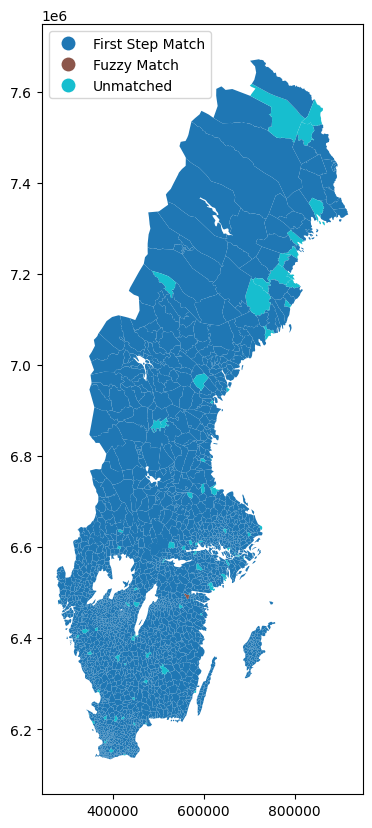

In [17]:
import matplotlib.pyplot as plt

# First, let's create a new column in the merged_df to indicate the type of match
merged_df['match_type'] = 'First Step Match'
merged_df.loc[merged_df['_merge'] == 'left_only', 'match_type'] = 'Unmatched'

# Then, let's update the match_type for the entries that were matched in the fuzzy matching step
fuzzy_matched_indices = fuzzy_match_df[fuzzy_match_df['matches'] != ''].index
merged_df.loc[merged_df.index.isin(fuzzy_matched_indices), 'match_type'] = 'Fuzzy Match'

# Now, let's plot the parishes with different colors for each match_type
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_df.plot(column='match_type', ax=ax, legend=True, categorical=True, legend_kwds={'loc': 'upper left'})

plt.show()


In [18]:
import numpy as np
from scipy.spatial.distance import cdist

# Select unmatched power stations
unmatched_df = merged_df[merged_df['match_type'] == 'Unmatched']

# convert ref_code_num to int
unmatched_df['ref_code_num'] = unmatched_df['ref_code_num'].astype(int)

# convert ref_code_num to int in geo_df
geo_df['ref_code_num'] = geo_df['ref_code_num'].astype(int)

# Compute distance between unmatched ref_code_nums and geo_df ref_code_nums
distances = cdist(unmatched_df[['ref_code_num']], geo_df[['ref_code_num']])


# Find index of closest geo_df ref_code_num for each unmatched ref_code_num
closest_idx = np.argmin(distances, axis=1)

# Get ref_code_num and geom_id from geo_df for closest ref_code_nums
closest_ref_codes = geo_df.loc[closest_idx, ['ref_code_num', 'geom_id']]

# keep only matched rows of merged_df
matched_df = merged_df[merged_df['match_type'] != 'Unmatched']

# then select just ref_code_num and geom_id
matched_df = matched_df[['ref_code_num', 'geom_id']]

# concatenate closest_ref_codes to matched_df
matched_df = pd.concat([matched_df, closest_ref_codes])

# write matched_df to excel file
matched_df.to_excel(root /"data/parishes/1900_1910_census_map_merged_data.xlsx", index=False)

matched_df

c:\Users\User\Documents\Recon\paper-3-analysis\.venv\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ref_code_num,geom_id
0,128717000,12558.0
1,128209000,12560.0
2,152717000,12561.0
3,051301000,12562.0
4,121408000,12563.0
...,...,...
2414,18014000,15942.0
2482,118001000,16045.0
2505,18102000,16075.0
2516,251471000,16087.0


Now to fix the 1930 parish names

In [19]:
import pandas as pd
df_census_1930 = pd.read_parquet(root / "data/census/df_ref.parquet")

In [20]:
# keep only arkbild and scbkod and lan from df_census_1930
df_census_1930_parish_names = df_census_1930[['arkbild', 'scbkod', 'lan']]

# rename columns arkbild and scbkod to name and ref_code
df_census_1930_parish_names = df_census_1930_parish_names.rename(columns={'arkbild': 'name', 'scbkod': 'ref_code'})

# keep only unique rows
df_census_1930_parish_names = df_census_1930_parish_names.drop_duplicates()

# export to excel file named "data/parishes/census_1930_parish_names.xlsx"
df_census_1930_parish_names.to_excel(root / "data/parishes/census_1930_parish_names.xlsx", index=False)

geo_df = gpd.read_file(root / "data/maps/Swedish_parishes_1926.geojson")

# export columns geom_id, ref_code, name to csv
geo_df[['geom_id', 'ref_code', 'name']].to_excel(root / "data/parishes/map_1926_names.xlsx", index=False)



In [21]:
census_data = pd.read_excel(root / "data/parishes/census_1930_parish_names.xlsx")
map_data = pd.read_excel(root / "data/parishes/map_1926_names.xlsx")

# Standardize the census data reference codes to 6 digits
census_data["ref_code"] = census_data["ref_code"].astype(str).str.zfill(6)

# Remove the "SE/" prefix from the map data reference codes
map_data["ref_code"] = map_data["ref_code"].str.replace("SE/", "")
# now move the last three digits of ref_code to another column called "ref_code_last_three"
map_data["ref_code_last_three"] = map_data["ref_code"].str[-3:]
# now remove the last three digits from ref_code
map_data["ref_code"] = map_data["ref_code"].str[:-3]

# Merge the two datasets based on 'ref_code'
merged_data = pd.merge(census_data, map_data, on='ref_code', how='left')

# show rows in merged_data where name_y is Nan
unmatched_census_data = merged_data[merged_data['name_y'].isna()]

# convert ref_code to int in unmatched_census_data and map_data
unmatched_census_data['ref_code'] = unmatched_census_data['ref_code'].astype(int)
map_data['ref_code'] = map_data['ref_code'].astype(int)

# for each row in unmatched_census_data, find the closest ref_code in map_data numerically
for index, row in unmatched_census_data.iterrows():
    closest_ref_code = map_data.loc[(map_data['ref_code'] - row['ref_code']).abs().argsort()[:1]]
    # set name_y in unmatched_census_data to name in closest_ref_code
    unmatched_census_data.loc[index, 'name_y'] = closest_ref_code['name'].values[0]
    # set geom_id in unmatched_census_data to geom_id in closest_ref_code
    unmatched_census_data.loc[index, 'geom_id'] = closest_ref_code['geom_id'].values[0]

# keep geom_id, ref_code from unmatched_census_data
unmatched_census_data = unmatched_census_data[['geom_id', 'ref_code']]

# keep rows of merged_data where name_y is not Nan
matched_census_data = merged_data[merged_data['name_y'].notna()]
# keep geom_id, ref_code from matched_census_data
matched_census_data = matched_census_data[['geom_id', 'ref_code']]

# concatenate matched_census_data and unmatched_census_data
merged_data = pd.concat([matched_census_data, unmatched_census_data])

# write out merged_data to excel file named "data/parishes/1930_census_map_merged_data.xlsx"
merged_data.to_excel(root / "data/parishes/1930_census_map_merged_data.xlsx", index=False)

merged_data

C:\Users\User\AppData\Local\Temp\ipykernel_16092\729722334.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_census_data['ref_code'] = unmatched_census_data['ref_code'].astype(int)


,geom_id,ref_code
0,14093.0,018001
2,14439.0,018803
3,13182.0,018805
4,15595.0,018804
5,15252.0,038031
...,...,...
1010,13058.0,178500
1013,13058.0,178500
1141,13313.0,230900
1150,15698.0,231300


## Now we want to join this population data to the parish data

For 1930

In [29]:
# count scbkod in df_census_1930 and create a dataframe with the counts with the column name "population" and the index name "ref_code"
population_df_1930 = df_census_1930['scbkod'].value_counts().rename_axis('ref_code').reset_index(name='population')

crosswalk_df = pd.read_excel(root / "data/parishes/1930_census_map_merged_data.xlsx")

# join population_df_1930 with crosswalk_df on ref_code
population_df_1930 = pd.merge(population_df_1930, crosswalk_df, on='ref_code', how='left')

# generate column called year = 1930
population_df_1930['year'] = 1930

population_df_1930.to_excel(root / "population_by_parish_1930_with_geom_id.xlsx", index=False)

For 1900 and 1910

In [26]:
# Load population data
population_df_1900_1910 = pd.read_excel(pathlib.Path(root / 'data/parishes/population_by_parish_1900_1910.xlsx'))
# concatenate "population_" to contents of year
population_df_1900_1910['year'] = population_df_1900_1910['year'].apply(lambda x: 'population_' + str(x))

# join to geom_id, read in crosswalk from root /"data/parishes/1900_1910_census_map_merged_data.xlsx"
crosswalk_df = pd.read_excel(root / "data/parishes/1900_1910_census_map_merged_data.xlsx")

# generate ref_code = ref_code_num as a string variable and add a leading zero to ref_code_num to make it 9 digits, and prepend "SE/" to ref_code
crosswalk_df['ref_code'] = crosswalk_df['ref_code_num'].astype(str).str.zfill(9)
crosswalk_df['ref_code'] = 'SE/' + crosswalk_df['ref_code']

# merge population_df_1900_1910 with crosswalk_df on ref_code
population_df_1900_1910 = pd.merge(population_df_1900_1910, crosswalk_df, on='ref_code', how='left')

# generate ref_code_num in population_df_1900_1910 as numberic variable
population_df_1900_1910['ref_code_num'] = population_df_1900_1910['ref_code'].str[3:].astype(int)

# where geom_id is null, find the closest ref_code in crosswalk_df numerically and set geom_id to geom_id in the closest ref_code
for index, row in population_df_1900_1910.iterrows():
    if pd.isnull(row['geom_id']):
        closest_ref_code = crosswalk_df.loc[(crosswalk_df['ref_code_num'] - row['ref_code_num']).abs().argsort()[:1]]
        population_df_1900_1910.loc[index, 'geom_id'] = closest_ref_code['geom_id'].values[0]

# keep geom_id, ref_code, year, n from population_df_1900_1910
population_df_1900_1910 = population_df_1900_1910[['geom_id', 'ref_code', 'year', 'n']]

# extract the year from the year column
population_df_1900_1910['year'] = population_df_1900_1910['year'].str[-4:].astype(int)
# rename n to population
population_df_1900_1910 = population_df_1900_1910.rename(columns={'n': 'population'})

# write out population_df_1900_1910 to excel file named "data/parishes/population_by_parish_1900_1910_with_geom_id.xlsx"
population_df_1900_1910.to_excel(root / "data/parishes/population_by_parish_1900_1910_with_geom_id.xlsx", index=False)

In [34]:
population_1930 = pd.read_excel(root / "population_by_parish_1930_with_geom_id.xlsx") 
# rename population to population_1930
population_1930 = population_1930.rename(columns={'population': 'population_1930'})

population_1900_1910 = pd.read_excel(root / "data/parishes/population_by_parish_1900_1910_with_geom_id.xlsx")
# drop ref_code
population_1900_1910 = population_1900_1910.drop(columns=['ref_code'])

population_1900 = population_1900_1910[population_1900_1910['year'] == 1900]
# rename population to population_1900
population_1900 = population_1900.rename(columns={'population': 'population_1900'})

population_1910 = population_1900_1910[population_1900_1910['year'] == 1910]
# rename population to population_1910
population_1910 = population_1910.rename(columns={'population': 'population_1910'})

df = pd.read_csv(root / "data/power-stations/power-stations-by-parish_with_area_and_treated_and_distance_to_line_and_touching_treated.csv")

# join df with population_1900 on geom_id
df = pd.merge(df, population_1900, on='geom_id', how='left')
# join df with population_1910 on geom_id
df = pd.merge(df, population_1910, on='geom_id', how='left')
# join df with population_1930 on geom_id
df = pd.merge(df, population_1930, on='geom_id', how='left')

# write out df to excel file named "data/power-stations/power-stations-by-parish_with_area_and_treated_and_distance_to_line_and_touching_treated_and_population.xlsx"
df.to_excel(root / "data/power-stations/power-stations-by-parish_with_area_and_treated_and_distance_to_line_and_touching_treated_and_population.xlsx", index=False)

Now we want to use this crosswalk to join to the population data